# Gamma ray spectrometry: full energy peak efficiency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
from scipy.optimize import curve_fit
from scipy.odr import unilinear, RealData, ODR
from scipy.interpolate import interp1d

In [48]:
def net_area(array):
    left_background = np.mean(array[:3])
    right_background = np.mean(array[-3:])
    return np.sum(array) - 0.5*array.size*(left_background + right_background)

In [49]:
peaks = pd.read_csv('final_peaks.csv')
isotopes = ['Am241', 'Ba133', 'Co60', 'Cs137', 'Eu152', 'Na22']
spectra = pd.DataFrame()
for isotope in isotopes:
    spectra[isotope] = pd.read_csv(
        'data_20220302/{:s}.Spe'.format(isotope), skiprows=12,
        nrows=2048, names=['counts'], dtype=float)

In [50]:
used_energy = np.array([1408, 1275, 662, 511, 344, 245, 122, 59.5])
used_idx = np.any(np.abs(np.atleast_2d(peaks.energy) - np.atleast_2d(used_energy).T) < 1, axis=0)
used_peaks = peaks[used_idx].sort_values('energy').reset_index(drop=True)
used_peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy
0,Am241,48.949766,1.0,14.093629,1.0,59.537,0.001
1,Eu152,107.910635,1.0,21.346148,1.0,121.783,0.009
2,Eu152,223.302063,1.0,35.958036,6.0,244.697,0.012
3,Eu152,319.267093,1.0,44.990162,6.0,344.274,0.012
4,Na22,468.748447,1.0,54.166027,1.0,511.006,0.010
5,Cs137,614.889306,1.0,61.092293,1.0,661.638,0.019
6,Na22,1171.435123,4.0,86.462154,1.0,1274.511,0.028
7,Eu152,1298.039945,1.0,91.915990,10.0,1408.024,0.030


In [51]:
slices = [
    slice(28, 70), slice(83, 135), slice(180, 270), slice(270, 370),
    slice(390, 550), slice(530, 710), slice(1060, 1300), slice(1200, 1400),
]
used_peaks['net_area'] = np.array([
    net_area(spectra[used_peaks.isotope[i]][slices[i]]) for i in range(8)
])
used_peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy,net_area
0,Am241,48.949766,1.0,14.093629,1.0,59.537,0.001,2.254857e+06
1,Eu152,107.910635,1.0,21.346148,1.0,121.783,0.009,4.838187e+05
2,Eu152,223.302063,1.0,35.958036,6.0,244.697,0.012,1.031350e+05
3,Eu152,319.267093,1.0,44.990162,6.0,344.274,0.012,2.864453e+05
4,Na22,468.748447,1.0,54.166027,1.0,511.006,0.010,2.136913e+05
5,Cs137,614.889306,1.0,61.092293,1.0,661.638,0.019,2.571470e+05
6,Na22,1171.435123,4.0,86.462154,1.0,1274.511,0.028,3.860500e+04
7,Eu152,1298.039945,1.0,91.915990,10.0,1408.024,0.030,3.499300e+04


In [52]:
slice_widths = [sl.stop - sl.start for sl in slices]
wide_slices = [
    slice(
        int(np.round(sl.start - 0.1*width)),
        int(np.round(sl.stop + 0.1*width))
    )
    for sl, width in zip(slices, slice_widths)
]
narrow_slices = [
    slice(
        int(np.round(sl.start + 0.1*width)),
        int(np.round(sl.stop - 0.1*width))
    )
    for sl, width in zip(slices, slice_widths)
]
wide_areas = np.array([
    net_area(spectra[used_peaks.isotope[i]][wide_slices[i]]) for i in range(8)
])
narrow_areas = np.array([
    net_area(spectra[used_peaks.isotope[i]][narrow_slices[i]]) for i in range(8)
])
delta_area = np.abs(wide_areas - narrow_areas)/2
used_peaks['delta_area'] = delta_area
used_peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy,net_area,delta_area
0,Am241,48.949766,1.0,14.093629,1.0,59.537,0.001,2.254857e+06,69473.833333
1,Eu152,107.910635,1.0,21.346148,1.0,121.783,0.009,4.838187e+05,29269.833333
2,Eu152,223.302063,1.0,35.958036,6.0,244.697,0.012,1.031350e+05,2142.000000
3,Eu152,319.267093,1.0,44.990162,6.0,344.274,0.012,2.864453e+05,20439.833333
4,Na22,468.748447,1.0,54.166027,1.0,511.006,0.010,2.136913e+05,12347.000000
5,Cs137,614.889306,1.0,61.092293,1.0,661.638,0.019,2.571470e+05,17464.500000
6,Na22,1171.435123,4.0,86.462154,1.0,1274.511,0.028,3.860500e+04,1763.000000
7,Eu152,1298.039945,1.0,91.915990,10.0,1408.024,0.030,3.499300e+04,2457.666667


In [53]:
times = []
for isotope in isotopes:
    time = pd.read_csv(
        'data_20220302/{:s}.Spe'.format(isotope), skiprows=9, sep=' ', index_col=False,
        nrows=1, usecols=[0], names=['time']).to_numpy().item()
    times.append(time)
    
test_date = np.datetime64('2022-03-02')
reference_date = np.array([
    '1999-03-01', '1994-02-25', '2003-02-01',
    '1994-05-05', '1998-03-01', '2014-08-01',
], dtype='datetime64')
elapsed_time = (test_date - reference_date)/np.timedelta64(1, 's')

initial_activity = np.array([411, 303, 400, 266, 441, 296])*1e3
half_life = np.array([432.0, 10.52, 5.27, 30.00, 13.52, 2.62])*86400*365.25
activity = initial_activity*2**(-elapsed_time/half_life)

In [54]:
times = pd.DataFrame({
    'isotope': isotopes, 'live_time': times, 'activity': activity,
    'elapsed_time': elapsed_time, 'half_life': half_life,
})
used_peaks = pd.merge(used_peaks, times)
used_peaks = used_peaks.sort_values('energy').reset_index(drop=True)
used_peaks['net_rate'] = used_peaks.net_area/used_peaks.live_time
used_peaks['delta_net_rate'] = used_peaks.delta_area/used_peaks.live_time
used_peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy,net_area,delta_area,live_time,activity,elapsed_time,half_life,net_rate,delta_net_rate
0,Am241,48.949766,1.0,14.093629,1.0,59.537,0.001,2.254857e+06,69473.833333,659,396106.872159,725932800.0,1.363288e+10,3421.634294,105.423116
1,Eu152,107.910635,1.0,21.346148,1.0,121.783,0.009,4.838187e+05,29269.833333,530,128826.395732,757468800.0,4.266588e+08,912.865409,55.226101
2,Eu152,223.302063,1.0,35.958036,6.0,244.697,0.012,1.031350e+05,2142.000000,530,128826.395732,757468800.0,4.266588e+08,194.594340,4.041509
3,Eu152,319.267093,1.0,44.990162,6.0,344.274,0.012,2.864453e+05,20439.833333,530,128826.395732,757468800.0,4.266588e+08,540.462893,38.565723
4,Na22,468.748447,1.0,54.166027,1.0,511.006,0.010,2.136913e+05,12347.000000,260,39804.383039,239328000.0,8.268091e+07,821.889744,47.488462
5,Cs137,614.889306,1.0,61.092293,1.0,661.638,0.019,2.571470e+05,17464.500000,285,139855.177183,878083200.0,9.467280e+08,902.270175,61.278947
6,Na22,1171.435123,4.0,86.462154,1.0,1274.511,0.028,3.860500e+04,1763.000000,260,39804.383039,239328000.0,8.268091e+07,148.480769,6.780769
7,Eu152,1298.039945,1.0,91.915990,10.0,1408.024,0.030,3.499300e+04,2457.666667,530,128826.395732,757468800.0,4.266588e+08,66.024528,4.637107


In [55]:
used_peaks['intensity'] = np.array([
    0.360, 0.284, 0.0751, 0.266, 1.807, 0.850, 0.9994, 0.209
])
used_peaks['activity'] *= used_peaks.intensity
used_peaks['net_efficiency'] = used_peaks.net_rate/used_peaks.activity
used_peaks['delta_net_efficiency'] = used_peaks.delta_net_rate/used_peaks.activity
used_peaks

,isotope,mean_peaks,peak_deltas,mean_widths,width_deltas,energy,delta_energy,net_area,delta_area,live_time,activity,elapsed_time,half_life,net_rate,delta_net_rate,intensity,net_efficiency,delta_net_efficiency
0,Am241,48.949766,1.0,14.093629,1.0,59.537,0.001,2.254857e+06,69473.833333,659,142598.473977,725932800.0,1.363288e+10,3421.634294,105.423116,0.3600,0.023995,0.000739
1,Eu152,107.910635,1.0,21.346148,1.0,121.783,0.009,4.838187e+05,29269.833333,530,36586.696388,757468800.0,4.266588e+08,912.865409,55.226101,0.2840,0.024951,0.001509
2,Eu152,223.302063,1.0,35.958036,6.0,244.697,0.012,1.031350e+05,2142.000000,530,9674.862319,757468800.0,4.266588e+08,194.594340,4.041509,0.0751,0.020113,0.000418
3,Eu152,319.267093,1.0,44.990162,6.0,344.274,0.012,2.864453e+05,20439.833333,530,34267.821265,757468800.0,4.266588e+08,540.462893,38.565723,0.2660,0.015772,0.001125
4,Na22,468.748447,1.0,54.166027,1.0,511.006,0.010,2.136913e+05,12347.000000,260,71926.520152,239328000.0,8.268091e+07,821.889744,47.488462,1.8070,0.011427,0.000660
5,Cs137,614.889306,1.0,61.092293,1.0,661.638,0.019,2.571470e+05,17464.500000,285,118876.900606,878083200.0,9.467280e+08,902.270175,61.278947,0.8500,0.007590,0.000515
6,Na22,1171.435123,4.0,86.462154,1.0,1274.511,0.028,3.860500e+04,1763.000000,260,39780.500409,239328000.0,8.268091e+07,148.480769,6.780769,0.9994,0.003733,0.000170
7,Eu152,1298.039945,1.0,91.915990,10.0,1408.024,0.030,3.499300e+04,2457.666667,530,26924.716708,757468800.0,4.266588e+08,66.024528,4.637107,0.2090,0.002452,0.000172


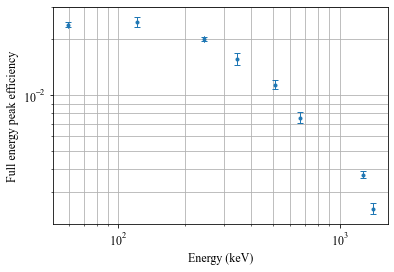

In [58]:
fig, ax = plt.subplots()
ax.errorbar(
    used_peaks.energy, used_peaks.net_efficiency, xerr=used_peaks.delta_energy,
    yerr=used_peaks.delta_net_efficiency, marker='.', linestyle='',
    capsize=3, elinewidth=1,)
plt.yscale('log')
plt.xscale('log')
ax.set(xlabel='Energy (keV)', ylabel='Full energy peak efficiency')
ax.grid(True, which='both')
ax.set_ylim(top=3e-2)
fig.savefig('figures/efficiency.pdf', facecolor='w', bbox_inches='tight')